In [122]:
import pandas as pd
import altair as alt
alt.renderers.set_embed_options(theme='dark')
pd.set_option('display.max_colwidth', None)

# Analysis & Charts

In [123]:
def claim(claim_hash):
    try:
        df_claim = pd.read_json(
            f'https://node-api.flipsidecrypto.com/api/v2/queries/{claim_hash}/data/latest',
            convert_dates=["BLOCK_TIMESTAMP"],
        )
    except Exception as e:
        print(e)
        return 
    return df_claim

In [124]:
class DataProvider:    
    
    def __init__(self):
        self.vote = 'a3efd3f0-724b-4a26-9f92-6083c7c52785'
        self.date_wallet = '074c2ad1-a842-442d-a0f5-6456b35be648'
    
    def get_vote(self):
        df = claim(self.vote)
        df.columns = [c.lower() for c in df.columns]
        return df
    
    def get_date_wallet(self):
        df = claim(self.date_wallet)
        df.columns = [c.lower() for c in df.columns]
        return df
    
   

In [125]:
dp = DataProvider()

In [126]:
df = dp.get_vote()[['date', 'address', 
       'block_timestamp', 'tx_id',
       'proposal_id', 'option', 'voting_power',  'balance','currency']]
df.head()

,date,address,block_timestamp,tx_id,proposal_id,option,voting_power,balance,currency
0,2022-05-18,terra1q7nrhflcd0yy0wff0f74h2lvqyke2k4vpf9z9g,2022-05-18 17:31:02.664,5D1DC8CE4B78E4386AEF662E8E8DCD801C8B39A551C044FA4EF5A8209BB9E93D,1623,VOTE_OPTION_YES,NaN,0.000000,LUNA
1,2022-05-18,terra19vrekcw6ecg3actfc3ecgtc2qe7y3wjurwje7a,2022-05-18 14:55:32.596,5A79883EAB01078920FA186CD377BCBE463022589ECE8ECBF06AA931EF708A5E,1623,VOTE_OPTION_YES,NaN,0.000000,LUNA
2,2022-05-18,terra1nk9e0l7xmfuvrylhwny7udh90h5wqkahxlj0c5,2022-05-18 18:41:31.731,299239CEC800FB742AC28AB976E2C6A8A0990FCE95010DC07401D9DE2DF7430E,1623,VOTE_OPTION_NO,NaN,0.000000,LUNA
3,2022-05-18,terra100a4ayedcdr0v2vrrqcc340anlpx2xg4tz0efq,2022-05-18 17:21:04.183,0E8C472DBB25EC0719702C7748291A30FE981C153B8FD1DE4F3A9538EBCD8BB6,1623,VOTE_OPTION_NO_WITH_VETO,NaN,0.000000,LUNA
4,2022-05-18,terra1s3s9vygaydnlwjw3s0tnz7faz59e032gmut3vq,2022-05-18 13:16:43.245,5068DB680D7264A0248E148491DA8B90B6D30A07526BF1DAEBB759E6D2628C12,1623,VOTE_OPTION_NO_WITH_VETO,NaN,1000.908722,LUNA


In [127]:
df.set_index('tx_id').to_json('../data/votes_tx.json')

In [128]:
df.option.unique()

array(['VOTE_OPTION_YES', 'VOTE_OPTION_NO', 'VOTE_OPTION_NO_WITH_VETO',
       'VOTE_OPTION_ABSTAIN'], dtype=object)

In [129]:
df['hours_since_start'] = (df.block_timestamp - df.block_timestamp.min()).apply(lambda x: x.total_seconds() / 3600)

In [130]:
df.option = df.option.map({'VOTE_OPTION_NO_WITH_VETO':'No with veto',
               'VOTE_OPTION_YES':'Yes',
               'VOTE_OPTION_NO':'No',
               'VOTE_OPTION_ABSTAIN':'Abstain'})

In [131]:
df.to_json('../data/votes.json',orient='records')

In [132]:
wc = dp.get_date_wallet()
wc['date'] = wc['min(date)']
wc['age'] = (pd.Timestamp('2022-05-20') - pd.to_datetime(wc.date)).apply(lambda x: x.total_seconds()/3600/24)

In [133]:
def typew(date):
    if(date<'2021-09-30'):
        return 'Pre-Col5'
    if((date>='2021-09-30')&(date<='2022-05-07')):
        return 'Post-Col5'
    if((date>'2021-05-07')):
        return 'Post-DePeg'

wc['typew'] = wc.date.apply(typew)

In [134]:
df.merge(wc[['address','age']], on='address', how='left').to_json('../data/votes.json',orient='records')

In [135]:
m = wc.merge(df, on='address')

<AxesSubplot:title={'center':'Number of Users'}>

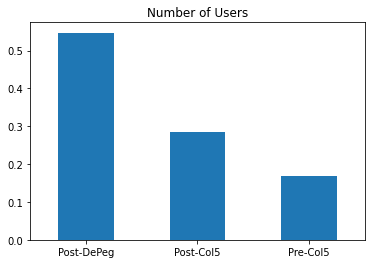

In [136]:
m.typew.value_counts(normalize=True).plot(kind='bar',rot=0, title='Number of Users')

<AxesSubplot:title={'center':'Voting Power'}, xlabel='typew'>

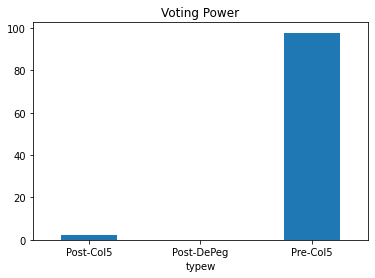

In [137]:
dfm = (m.groupby('typew').balance.sum())/1000000
(dfm/dfm.sum()*100).plot(kind='bar', rot=0, title='Voting Power')

<AxesSubplot:title={'center':'Pre-Col5'}>

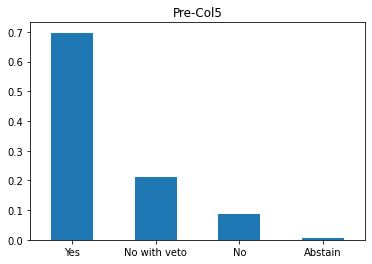

In [144]:
m.option.value_counts(normalize=True).plot(kind='bar', rot=0, title=t)

<AxesSubplot:title={'center':'Pre-Col5'}>

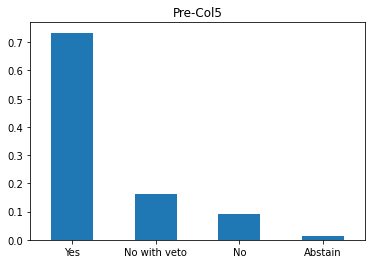

In [143]:
t='Pre-Col5'
m[m.typew==t].option.value_counts(normalize=True).plot(kind='bar', rot=0, title=t)

In [139]:
m[m.typew=='Post-DePeg'].option.value_counts(normalize=True)

Yes             0.728565
No with veto    0.209439
No              0.058332
Abstain         0.003664
Name: option, dtype: float64

In [140]:
m[m.typew=='Post-Col5'].option.value_counts(normalize=True)

Yes             0.616315
No with veto    0.242194
No              0.133615
Abstain         0.007876
Name: option, dtype: float64

In [141]:
m[m.typew=='Pre-Col5'].option.value_counts(normalize=True)

Yes             0.733875
No with veto    0.161968
No              0.092212
Abstain         0.011945
Name: option, dtype: float64